In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [2]:
TRAIN_DIR = r'F:\VRA\train'
TEST_DIR = r'F:\VRA\test'
IMG_SIZE = 50
LR = 0.9734
MODEL_NAME = 'catdogmodel'

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (50,50))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save(r'F:\VRA\train_data.npy',training_data)
    return training_data

In [23]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        img_num = img.split('.')[0]
        path = os.path.join(TEST_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (50, 50))
        testing_data.append([np.array(img), img_num])
    np.save(r'F:\VRA\test_data.npy',testing_data)
    return testing_data

In [6]:
train_data = create_train_data()

100%|██████████| 25000/25000 [02:54<00:00, 142.95it/s]


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [10]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.64534 | time: 127.353s
| Adam | epoch: 003 | loss: 11.64534 - acc: 0.4942 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.41623 | time: 128.672s
| Adam | epoch: 003 | loss: 11.41623 - acc: 0.5042 | val_loss: 10.73005 - val_acc: 0.5340 -- iter: 24500/24500
--


In [14]:
model.save('catdogmodel2.model')

INFO:tensorflow:C:\Users\Phan\catdogmodel2.model is not in all_model_checkpoint_paths. Manually adding it.


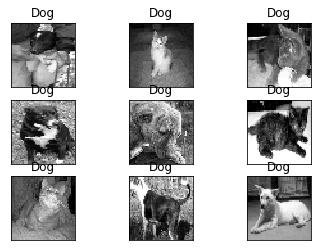

In [30]:
import matplotlib.pyplot as plt

#test_data = process_test_data()
test_data = np.load(r'F:\VRA\test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:9]):
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3,3,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()